In [7]:
import torch
from utils import HelicoDatasetClassification
from model import HelicobacterClassifier    
torch.manual_seed(42)
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_model = 'C:/Users/Usuario/Documents/GitHub/MED-GIA/Classfication/models/HelicobacterClassifier_final.pth'

In [ ]:

dataset = HelicoDatasetClassification()

model = HelicobacterClassifier()
for n in range (5):
    model = torch.load_state_dict(torch.load(r"C:\Users\Usuario\Documents\GitHub\MED-GIA\Classfication\models\HelicobacterClassifier_fold" + str(n) + ".pth"))  
    globals()[f'model_fold_{n}'] = model

# Ensemble voting to predict new patches
def ensemble_predict(models, img):
    outputs = [torch.softmax(model(img)) for model in models]
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs, dim=0)
    _, predicted = torch.max(outputs.data, 1)
    return predicted
# Load models into a list
models = [globals()[f'model_fold_{n}'] for n in range(5)]
# Predict using ensemble
ensemble_predictions = []
for i, data in enumerate(val_loader):
    img, label = data
    img = img.to(device)
    label = label.to(device)
    predicted = ensemble_predict(models, img)
    ensemble_predictions.append(predicted.cpu().numpy())
ensemble_predictions = np.concatenate(ensemble_predictions)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_28576\2998840635.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


<All keys matched successfully>

In [16]:
val_loader = DataLoader(test_dataset, batch_size=1) 
model.to(device)
model.eval()
total = 0 
correct = 0 
for i, data in enumerate(val_loader):
                    img, label = data
                    img = img.to(device)
                    label = label.to(device)
                    output = model(img)
                    print(output)
                    _, predicted = torch.max(output.data, 1)
                    print(predicted)
                    total += label.size(0)

                    correct += (predicted == label).sum().item()
accuracy = 100 * correct / total

print('Accuracy of the network on the test images: %d %%' % (accuracy))

tensor([[-184.5305,  194.3138]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1], device='cuda:0')
tensor([[-97.4134, 101.8757]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1], device='cuda:0')
tensor([[ 2.8217, -2.9337]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[ 7.9021, -8.1116]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[-56.8173,  59.3872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1], device='cuda:0')
tensor([[ 2.1547, -1.8355]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[ 2.7330, -2.6612]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[ 2.6855, -2.5498]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[ 5.9092, -5.6760]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')
tensor([[-123.7413,  116.0425]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(

Confusion Matrix:
[[214   0]
 [ 17 305]]


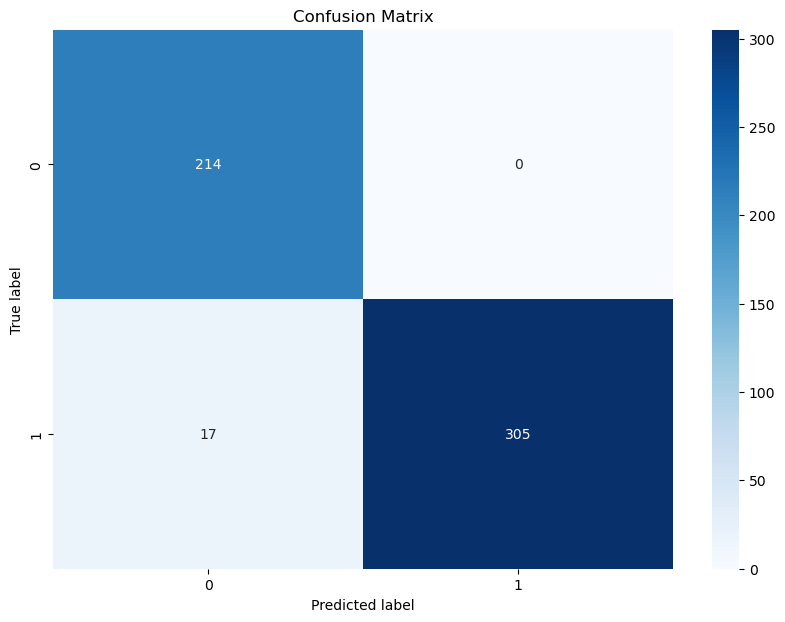

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       214
           1       1.00      0.95      0.97       322

    accuracy                           0.97       536
   macro avg       0.96      0.97      0.97       536
weighted avg       0.97      0.97      0.97       536



In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Añadir seaborn para una mejor visualización

# Collect all true labels and predicted labels
true_labels = []
predicted_labels = []

for data in val_loader:
    img, label = data
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    true_labels.append(label.cpu().numpy())
    predicted_labels.append(predicted.cpu().numpy())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Compute classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()